In [1]:
## plot within the notebook
%matplotlib inline
import warnings
import numpy as np
## No annoying warnings
warnings.filterwarnings('ignore')

In [2]:
from astrobject.utils.plot.skybins import SurveyFieldBins
ztf_fields = np.genfromtxt('data/ZTF_Fields.txt', comments='%')
bins = SurveyFieldBins(ra=ztf_fields[:,1], dec=ztf_fields[:,2])
# Fields are defined by their midpoints
# Default width and height are set to 7 degrees for now
# There is more field overlap the closer you get to the poles (no surprise)

In [3]:
# Make a mock survey plan (by no means realistic, just trying to capture the effect of
# moving the observed part of the sky along according to the seasons)
import astrobject.simulation as simul
obs_days = np.arange(58000, 58181, 1)

dec_range = [-20, 60]
ra_range = [0, 90]
ra_shift = 360. / 365.25

t_obs = 60.
t_night = 8. * 3600

obs = {'time': [], 'field': [], 'band': [], 'skynoise': []}
for d in obs_days:
    # Find fields that have their center within dec_range and in ra_range shifted by ra_shift for each day
    field_idx = np.where((bins.ra > ra_range[0] + ra_shift * (d - obs_days[0])) &
                         (bins.ra < ra_range[1] + ra_shift * (d - obs_days[0])) &
                         (bins.dec > dec_range[0]) & (bins.dec < dec_range[1]))[0]
    
    # Sort first by ra then by dec
    field_idx = field_idx[np.argsort(bins.ra[field_idx])]
    field_idx = field_idx[np.argsort(bins.dec[field_idx])]

    for k, t in enumerate(np.arange(0, t_night, t_obs)):
        obs['time'].append(d + t / 86400.)
        obs['field'].append(field_idx[k % len(field_idx)])
        obs['band'].append(['desr', 'desg'][(k / len(field_idx)) % 2])
        obs['skynoise'].append(150.) # TBD later, completely random number for now
        
plan = simul.SurveyPlan(time=obs['time'], band=obs['band'], obs_field=obs['field'],
                        skynoise=obs['skynoise'],
                        fields=dict(ra=ztf_fields[:,1], dec=ztf_fields[:,2]))

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f08590a5e90>,
 'cbar': <matplotlib.colorbar.ColorbarBase at 0x7f08586ba1d0>,
 'collection': <matplotlib.collections.PolyCollection at 0x7f08585ec0d0>,
 'figure': <matplotlib.figure.Figure at 0x7f08590a5650>}

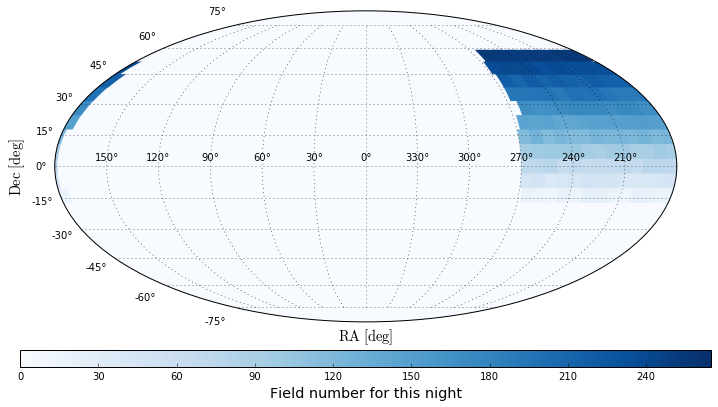

In [4]:
# Example of selected fields (last of the nights in the mock survey)
# The fields are number by the order in which they are observed.
vals = np.zeros(bins.nbins)
for k,l in enumerate(field_idx):
    vals[l] = k
    
bins.imshow(vals, cblabel="Field number for this night")

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f085850d8d0>,
 'cbar': <matplotlib.colorbar.ColorbarBase at 0x7f0856b21790>,
 'collection': <matplotlib.collections.PolyCollection at 0x7f0858724110>,
 'figure': <matplotlib.figure.Figure at 0x7f085858aed0>}

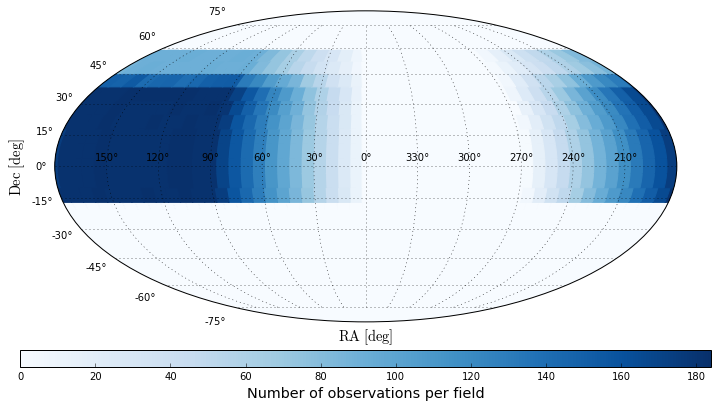

In [5]:
# Number of pointings per field
vals, _ = np.histogram(obs['field'], bins=range(bins.nbins + 1))
bins.imshow(vals, cblabel="Number of observations per field")

In [6]:
tr = simul.sn_generator([0.01,0.1], ratekind="basic", 
                        mjd_range=[obs_days[0] - 60, obs_days[-1] + 25])
# ratekind is the rate of the transient: basiclow = 1e3 
# -> comoving volumetric rate at each redshift in units of yr^-1 Mpc^-3.
# type_ is the type of transient. 
# This will parse the ratekind+type_ do get the good rate function

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f0856a7b210>,
 'cbar': <matplotlib.colorbar.ColorbarBase at 0x7f08569e1750>,
 'collection': <matplotlib.collections.PolyCollection at 0x7f0858763c10>,
 'figure': <matplotlib.figure.Figure at 0x7f0856a77dd0>}

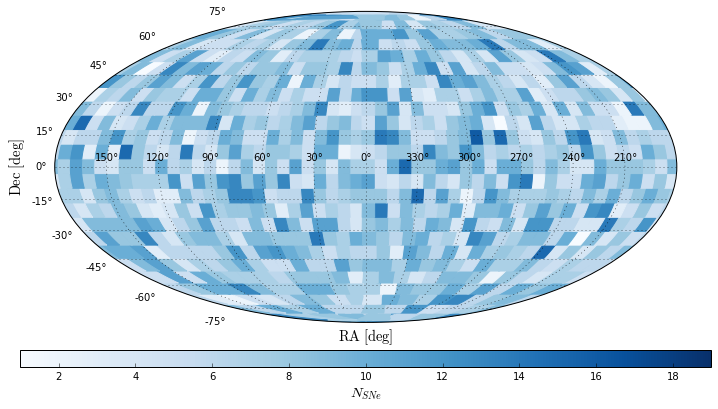

In [7]:
tr.hist_skycoverage(bins=bins)
# Since the fields can overlap, some SNe will be counted twice
# Overlapping fields partly obscure previously drawn 
# Some distortions when drawing fields near the poles (to be fixed later)

SNe observed: 1473 out of 6305


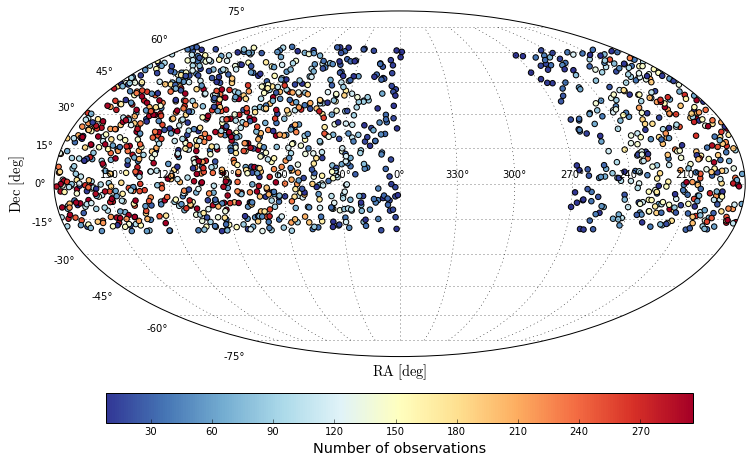

In [8]:
# SimulSurvey class collects all required components, Transient generator, survey plan and instruments
instprop = {"desg":{"gain":1,"zp":30,"zpsys":'ab'},
            "desr":{"gain":1,"zp":30,"zpsys":'ab'}}

survey = simul.SimulSurvey(generator=tr, plan=plan, instprop=instprop)

# Generate the lightcurves. This first determines the dates on which each transient was observed
# to keep the number of lightcurve points that are calculated to a minimum
lcs = survey.get_lightcurves()
n_obs = np.array([len(a) for a in survey.plan.observed])
survey.generator.show_skycoverage(cscale=n_obs, cblabel="Number of observations", mask=(n_obs > 0))
print 'SNe observed: %i out of %i'%(np.sum(n_obs > 0), survey.generator.ntransient)

In [9]:
lcs[:10]

[None, None, None, None, None, None, <Table masked=False length=282>
      time       band        flux        fluxerr      zp   zpsys  
    float64    string32    float64       float64    int64 string16
 ------------- -------- ------------- ------------- ----- --------
 58012.0736111     desr 1084.78804599 153.542027244    30       ab
 58012.2590278     desg 1002.32615551 153.141998623    30       ab
 58013.0743056     desr 2276.94917953 157.070734247    30       ab
 58013.2569444     desg 1947.35301881  156.20778299    30       ab
 58014.0694444     desr 3905.65487434 162.719302531    30       ab
 58014.2513889     desg 3711.71717035 162.032592278    30       ab
 58015.0708333     desr 6858.54565911 171.222701836    30       ab
 58015.0798611     desr 6538.31528755 171.307496332    30       ab
   58015.25625     desg 6916.42106955 171.021457681    30       ab
 58015.2652778     desg 6947.55271957 171.111467076    30       ab
           ...      ...           ...           ...   ...   

In [10]:
lcs[6].meta

{'c': 0.11167284637550245,
 't0': 58030.640106829043,
 'x0': 0.00091012970171094952,
 'x1': 0.55620395996851213,
 'z': 0.05454832254480853}

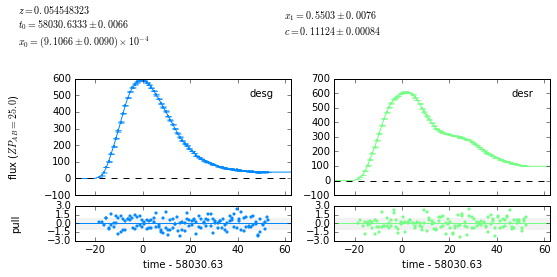

In [12]:
lc = lcs[6]

import sncosmo
model = sncosmo.Model(source=survey.generator.lightcurve_model)
model.set(z=lc.meta['z'])
res, fitted_model = sncosmo.fit_lc(lc, model,
                                   ['t0', 'x0', 'x1', 'c'])

_ = sncosmo.plot_lc(lc, model=fitted_model, errors=res.errors)